### A larger more pythonic example

A version of @inconvergent's wind rendering to p55py.
https://github.com/inconvergent/wind

In [1]:
import p55py.sketch
from IPython.display import display

In [2]:
# some color constants (we'll be able to override one from the panel)

BACK = (255,255,255,255)
FRONT = (0, 0, 0, 255)
LIGHT = (0, 100, 0, 255)
CYAN = (0, 100, 100, 255)
BLUE = (0, 0, 200, 255)
RED = (128, 0, 0, 255)

FRONTCOLORS = [FRONT, LIGHT, CYAN, BLUE, RED]

In [3]:
# simulation constants (we'll expose two in the panel)
NMAX = 10**6
SIZE = 200
ONE = 1.5/SIZE
LINEWIDTH = ONE*1.1

INIT_NUM = 4

STP = ONE*3

ANGLE_STP = 0.5
ANGLE_LOCAL_STP = 0.8

In [4]:
from modules.wind import Wind

# setup to initialize
def setup_wind(canvas):
    global ANGLE_STP, ANGLE_LOCAL_STP
    canvas.wind = Wind(NMAX, SIZE, STP, ANGLE_STP, ANGLE_LOCAL_STP)
    canvas.wind.rnd_seed(INIT_NUM)

# step updates the model
def step_wind(canvas):
    res = canvas.wind.step()

# render draws the model (idempotent)
def render_wind(canvas):
    canvas.fill(225)
    canvas.cur_outline = canvas.cur_fill
    canvas.rectangle(0,0,canvas.width,canvas.height)
    canvas.fill(0)

    xy = canvas.wind.xy
    n = canvas.wind.n
    r = canvas.wind.r

    for i,x in enumerate(xy[:n,:]):
        canvas.cur_fill = FRONTCOLORS[r[i]]
        canvas.cur_outline = FRONTCOLORS[r[i]]
        canvas.ellipse(int(canvas.width*x[0]), int(canvas.height*x[1]), 2, 2)

    for i,p in enumerate(canvas.wind.p[:n]):
        if p>-1:
            canvas.cur_fill = FRONTCOLORS[r[i]]
            canvas.cur_outline = FRONTCOLORS[r[i]]
            source = canvas.width * xy[p,:].flatten()
            dest = canvas.width * xy[i,:].flatten()
            canvas.line(source[0], source[1], dest[0], dest[1])

### With no panel, straightforward to use

In [5]:
sketch = p55py.sketch.Sketch(400, 400, setupfn=setup_wind, stepfn=step_wind, renderfn=render_wind)
sketch.canvas.redraw_freq = 5  # draw only every 5th step
sketch.widget()

# WARNING: settings panel below is currently NOT WORKING
----

In [1]:
import ipywidgets as widgets
import webcolors

ImportError: No module named 'webcolors'

### Wiring up a panel is currently cumbersome, but doable
Note that in addition to the model parameters above, this panel also exposes some more generic settings:
 * the current random seed
 * whether the seed is auto-incremented each run (disable to manually return to known good seed)
 * the draw frequency (updates per render)

In [6]:
def wrapped_wind_settings(wrapper):
    def settings_updated(randomSeed, incSeed, drawFreq, ASTP, ALOCAL, color):
        global FRONTCOLORS
        global ANGLE_STP
        global ANGLE_LOCAL_STP
        wrapper.randomSeed = randomSeed
        wrapper.incSeedOnStop = incSeed
        wrapper.redrawFreq = drawFreq
        ANGLE_STP = ASTP
        ANGLE_LOCAL_STP = ALOCAL
        t = webcolors.html5_parse_legacy_color(color)
        FRONTCOLORS[0] = (t[0], t[1], t[2], 255)
        return None
    return settings_updated

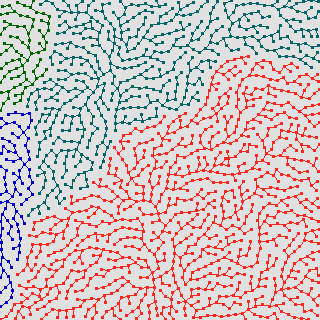

In [7]:
wrapper = P55Wrapper(setupfn=setup_wind, stepfn=step_wind, renderfn=render_wind)
settings_callback = wrapped_wind_settings(wrapper)
cp = widgets.ColorPicker()
seedWidget = widgets.IntText(wrapper.randomSeed)
incSeedWidget = widgets.Checkbox(description='Inc Seed on Stop', value=wrapper.incSeedOnStop)
rw = widgets.IntSlider(value=1,min=1,max=20)
asw = widgets.FloatSlider(value=0.5,min=0,max=2)
alsw = widgets.FloatSlider(value=0.8,min=0,max=2)
w = widgets.interactive(settings_callback, randomSeed=seedWidget, incSeed=incSeedWidget, drawFreq=rw, ASTP=asw, ALOCAL=alsw, color=cp)
wrapper.addSettingsPane(w, seedWidget)
wrapper.play.max = 1000
wrapper.redrawFreq = 5
display(wrapper.widget)